# Customer outflow

Customers began to leave the bank. Every month. A little, but noticeable. Bank marketers have found that it is cheaper to retain current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not.

## Data preparation

Installing the phik library

In [1]:
pip install phik

Importing libraries

In [2]:
import phik
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo

from phik import report
from sklearn import tree
from tqdm import tqdm

from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

Download the data and save it to the data dataframe, specify 0 in the index_col variable. Show the first 5 lines

In [3]:
data.head()

CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
RowNumber                                                                     
1            15634602  Hargrave          619    France  Female   42     2.0   
2            15647311      Hill          608     Spain  Female   41     1.0   
3            15619304      Onio          502    France  Female   42     8.0   
4            15701354      Boni          699    France  Female   39     1.0   
5            15737888  Mitchell          850     Spain  Female   43     2.0   

             Balance  NumOfProducts  HasCrCard  IsActiveMember  \
RowNumber                                                        
1               0.00              1          1               1   
2           83807.86              1          0               1   
3          159660.80              3          1               0   
4               0.00              2          0               0   
5          125510.82              1          1               1   

           EstimatedSalary  Exited  
RowNumber                           
1                101348.88       1  
2                112542.58       0  
3                113931.57       1  
4                 93826.63       0  
5                 79084.10       0

Let's check the data types and missing values

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


We see missing values in the tenure column. Let's see if there is any dependence and if this data can be filled in somehow. To do this, let's study the data. Let's start by building histograms

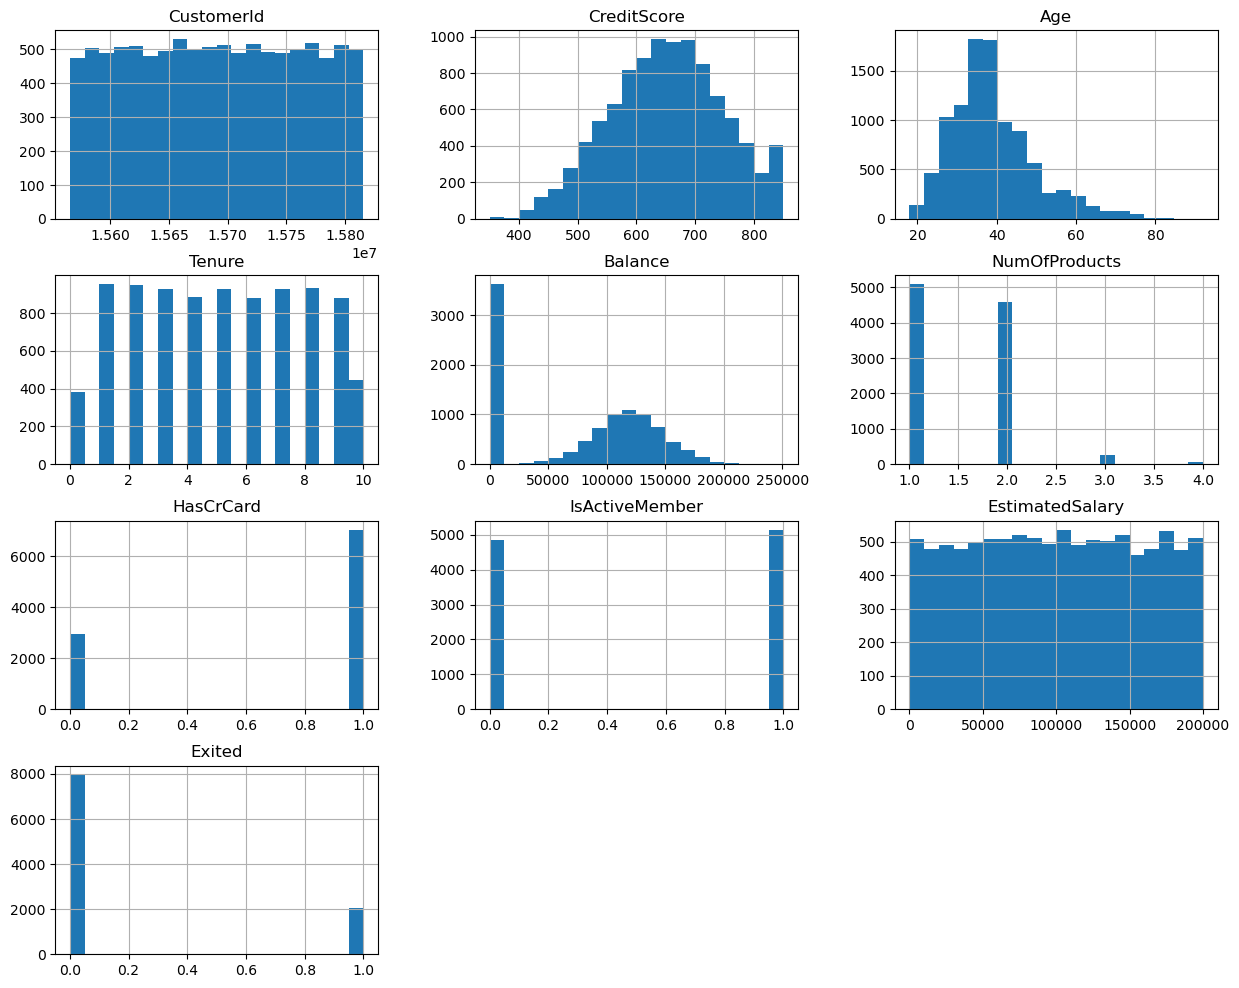

In [5]:
data.hist(figsize=(15, 12), bins=20)
plt.show()

According to the data, you can see the following:

1. Active and inactive users are about equally divided
2. Salaries are distributed suspiciously evenly
3. There are a lot of users with zero balance
4. About 20% of those who refused the bank's services.
5. The vast majority of users use one or two bank products.
6. The median age is around 40 years old.
7. The duration of using the bank's services is evenly distributed among users, but those who use it for less than a year or more than 10 years are knocked out

Let's check the correlation between the features. We do this, among other things, in order to determine the relationship between tenure and other signs to fill missing values.

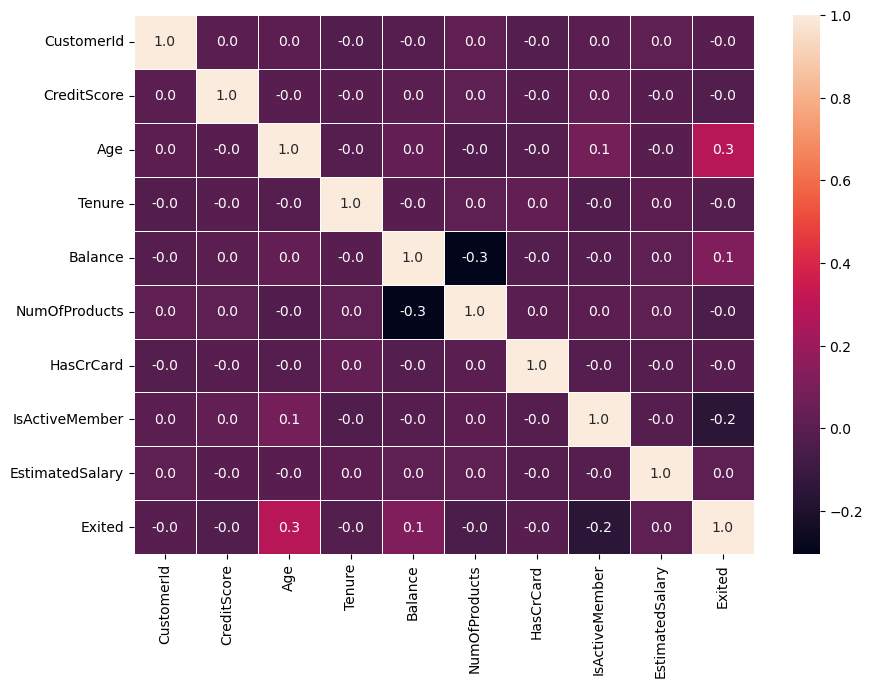

In [6]:
data_corr = data.corr()
fig, ax = plt.subplots(figsize=(10,7))    
plt.show(sns.heatmap(data_corr, annot=True, fmt=".1f", linewidths=.5))

Let's clarify the distribution of classes as a percentage

In [7]:
data['Exited'].value_counts() / data['Exited'].count() * 100

0    79.63
1    20.37
Name: Exited, dtype: float64

Delete the lines where the values are missing

In [8]:
data = data.dropna().reset_index().set_index('RowNumber')

Let's check the percentage distribution of classes after deleting the missing data

In [9]:
data['Exited'].value_counts() / data['Exited'].count() * 100

0    79.606204
1    20.393796
Name: Exited, dtype: float64

Let's divide the samples into training, validation and test ones. Let's remove the columns with the last name and id from the predictors, since this information is unlikely to help us classify users correctly

In [10]:
features = data.drop(['Exited', 'Surname', 'CustomerId'], axis=1)
target = data['Exited']

We convert the data in the Geography and Gender columns into numerical variables using the OHE method. In order not to fall into the trap of fictitious signs, we will pass drop_first=True.

I am passing the name of the columns to the list for converting categorical values into numerical ones

In [11]:
columns_to_transform = ['Geography', 'Gender']
features[columns_to_transform].head()

Geography  Gender
RowNumber                  
1            France  Female
2             Spain  Female
3            France  Female
4            France  Female
5             Spain  Female

In [12]:
# create an OHE object
ohe = OneHotEncoder(drop='first')
# transform data 
df_encoded = ohe.fit_transform(features[columns_to_transform])
# create a new dataframe with transformed data
df_encoded_df = pd.DataFrame(df_encoded.toarray(), columns=ohe.get_feature_names(columns_to_transform), index=features.index)
# combine the resulting dataframe with the original one and remove the extra columns
features = pd.concat([features, df_encoded_df], axis=1).drop(columns_to_transform, axis=1)
# displaying the size of this dataframe
print(features.shape)
# displaying the resulting dataframe
features.head()

(9091, 11)


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
RowNumber                                                                  
1                  619   42     2.0       0.00              1          1   
2                  608   41     1.0   83807.86              1          0   
3                  502   42     8.0  159660.80              3          1   
4                  699   39     1.0       0.00              2          0   
5                  850   43     2.0  125510.82              1          1   

           IsActiveMember  EstimatedSalary  Geography_Germany  \
RowNumber                                                       
1                       1        101348.88                0.0   
2                       1        112542.58                0.0   
3                       0        113931.57                0.0   
4                       0         93826.63                0.0   
5                       1         79084.10                0.0   

           Geography_Spain  Gender_Male  
RowNumber                                
1                      0.0          0.0  
2                      1.0          0.0  
3                      0.0          0.0  
4                      0.0          0.0  
5                      1.0          0.0

Let's apply the phi_matrix() method to the dataframe with features and round the values to hundredths

In [13]:
phik_overview = features.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


CreditScore   Age  Tenure  Balance  NumOfProducts  \
CreditScore               1.00  0.00    0.00     0.00           0.04   
Age                       0.00  1.00    0.05     0.03           0.14   
Tenure                    0.00  0.05    1.00     0.06           0.06   
Balance                   0.00  0.03    0.06     1.00           0.37   
NumOfProducts             0.04  0.14    0.06     0.37           1.00   
HasCrCard                 0.01  0.03    0.03     0.05           0.00   
IsActiveMember            0.04  0.19    0.03     0.00           0.06   
EstimatedSalary           0.04  0.06    0.00     0.00           0.03   
Geography_Germany         0.03  0.09    0.02     0.58           0.10   
Geography_Spain           0.04  0.00    0.00     0.20           0.05   
Gender_Male               0.00  0.03    0.03     0.01           0.07   

                   HasCrCard  IsActiveMember  EstimatedSalary  \
CreditScore             0.01            0.04             0.04   
Age                     0.03            0.19             0.06   
Tenure                  0.03            0.03             0.00   
Balance                 0.05            0.00             0.00   
NumOfProducts           0.00            0.06             0.03   
HasCrCard               1.00            0.00             0.00   
IsActiveMember          0.00            1.00             0.04   
EstimatedSalary         0.00            0.04             1.00   
Geography_Germany       0.00            0.02             0.02   
Geography_Spain         0.02            0.02             0.03   
Gender_Male             0.00            0.04             0.03   

                   Geography_Germany  Geography_Spain  Gender_Male  
CreditScore                     0.03             0.04         0.00  
Age                             0.09             0.00         0.03  
Tenure                          0.02             0.00         0.03  
Balance                         0.58             0.20         0.01  
NumOfProducts                   0.10             0.05         0.07  
HasCrCard                       0.00             0.02         0.00  
IsActiveMember                  0.02             0.02         0.04  
EstimatedSalary                 0.02             0.03         0.03  
Geography_Germany               1.00             0.50         0.03  
Geography_Spain                 0.50             1.00         0.02  
Gender_Male                     0.03             0.02         1.00

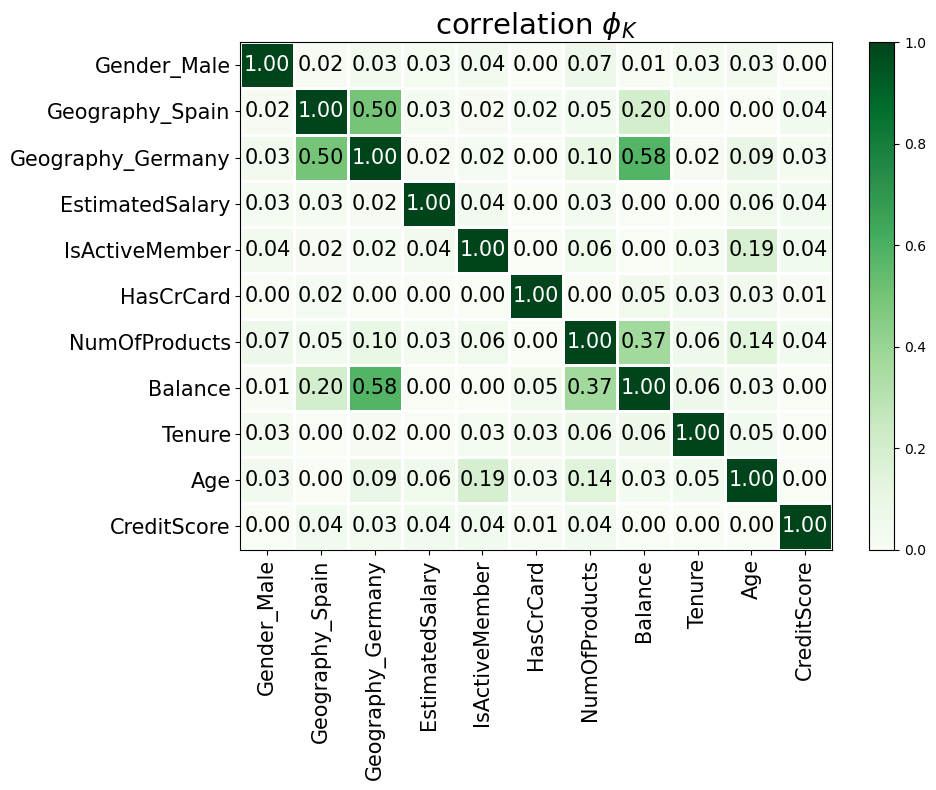

In [14]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

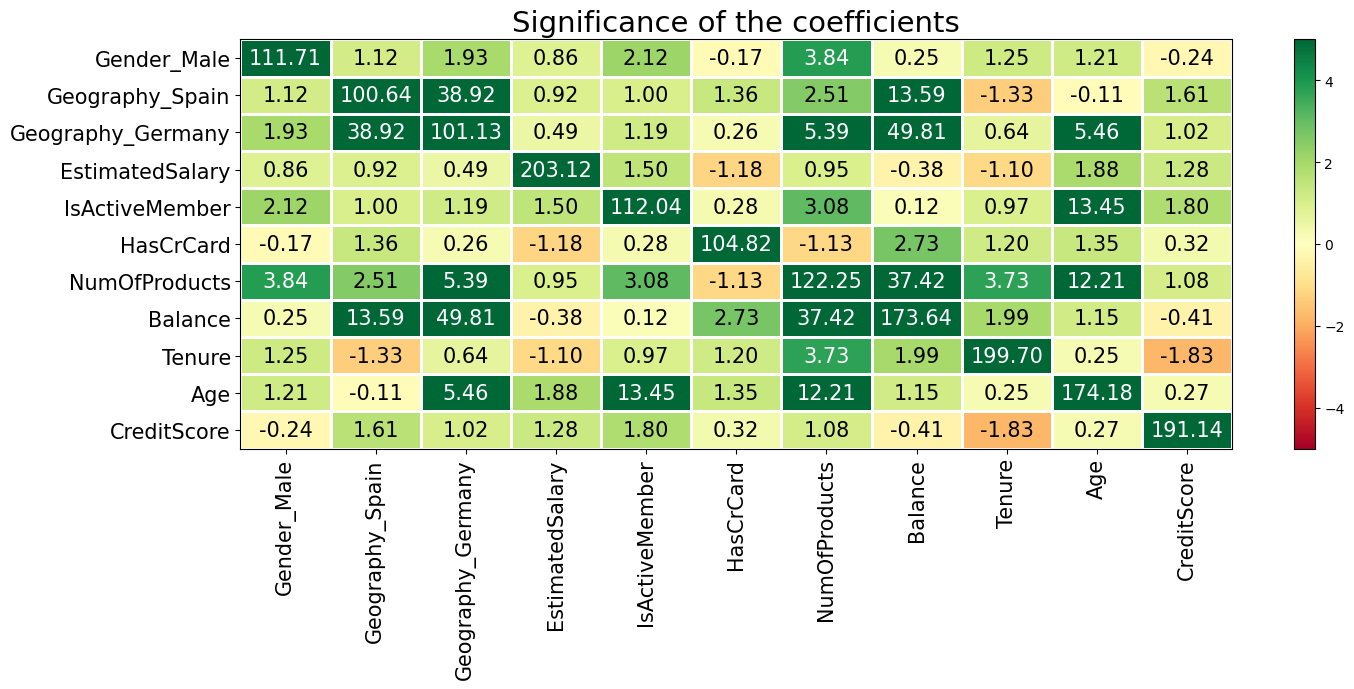

In [15]:
significance_overview = features.significance_matrix(interval_cols=features.columns)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(15, 7))
plt.tight_layout()

Let's divide the samples into training, validation and test samples in the proportions of 60/20/20. First, let's separate the training sample

In [16]:
 features_train, valid_test_features, target_train, valid_test_target = train_test_split(features, 
                                                                                         target, 
                                                                                         stratify=target, 
                                                                                         test_size=0.4, 
                                                                                         random_state=12345)

We check whether the training sample now really makes up 60% of the entire dataframe

In [17]:
print('Size of the train dataframe:', features_train.shape[0] / features.shape[0])

Size of the train dataframe: 0.5999340006599934


We standardize the data. To do this, select the name of the features with quantitative characteristics in a separate list

In [18]:
list_of_featers_to_std = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']

In [19]:
# passing the Standard Scaler to the scalar variable
scaler = StandardScaler()
# we train and transform the dataframe
df_standardized = pd.DataFrame(scaler.fit_transform(features_train[list_of_featers_to_std]), columns=list_of_featers_to_std, index=features_train.index)
# merge the standardized columns with the remaining columns in the original dataframe
features_train = pd.concat([features_train[features_train.drop(list_of_featers_to_std, axis=1).columns], df_standardized], axis=1)
# print the standardized dataframe
features_train

HasCrCard  IsActiveMember  Geography_Germany  Geography_Spain  \
RowNumber                                                                  
9724               0               0                0.0              0.0   
1225               1               0                0.0              1.0   
8378               1               1                0.0              1.0   
8015               1               1                0.0              1.0   
2492               1               1                0.0              1.0   
...              ...             ...                ...              ...   
3892               1               0                1.0              0.0   
2676               1               1                1.0              0.0   
4218               1               1                1.0              0.0   
5818               0               1                1.0              0.0   
2672               0               1                0.0              1.0   

           Gender_Male  CreditScore       Age    Tenure   Balance  \
RowNumber                                                           
9724               1.0    -1.292898 -0.660843  0.686341  0.786636   
1225               0.0    -1.563714  0.778434  1.034232  0.833795   
8378               1.0     1.581914  0.106771 -0.357331 -1.222967   
8015               0.0     0.842379  0.010820 -1.053112  0.807063   
2492               0.0    -0.397123 -1.236554 -0.357331 -1.222967   
...                ...          ...       ...       ...       ...   
3892               0.0     0.759051 -1.044650 -0.009440  0.248750   
2676               1.0     0.988203 -0.085132 -0.009440 -0.180942   
4218               1.0    -0.657523 -0.372988 -0.009440  0.727784   
5818               1.0    -0.386707  2.889373  1.382122  0.038092   
2672               1.0     1.550666 -0.372988  0.686341 -1.222967   

           EstimatedSalary  NumOfProducts  
RowNumber                                  
9724             -0.223548      -0.910943  
1225              1.383021      -0.910943  
8378             -0.308331       0.789359  
8015             -0.430980      -0.910943  
2492              1.392642       0.789359  
...                    ...            ...  
3892              0.761788      -0.910943  
2676              0.704706       0.789359  
4218             -1.323749      -0.910943  
5818             -1.579750      -0.910943  
2672              0.714845       0.789359  

[5454 rows x 11 columns]

Standardizing validation and test dataframes

In [20]:
# transform dataframe
df_standardized = pd.DataFrame(scaler.transform(valid_test_features[list_of_featers_to_std]), columns=list_of_featers_to_std, index=valid_test_features.index)
# combining a standardized dataframe with data that do not need standardization
valid_test_features = pd.concat([valid_test_features[valid_test_features.drop(list_of_featers_to_std, axis=1).columns], df_standardized], axis=1)
valid_test_features

HasCrCard  IsActiveMember  Geography_Germany  Geography_Spain  \
RowNumber                                                                  
9821               0               0                1.0              0.0   
763                0               0                1.0              0.0   
4151               1               0                0.0              0.0   
1322               0               0                0.0              0.0   
1859               1               1                0.0              0.0   
...              ...             ...                ...              ...   
8443               0               0                0.0              0.0   
9893               0               1                0.0              1.0   
129                1               0                0.0              0.0   
5877               1               0                0.0              0.0   
9626               1               1                1.0              0.0   

           Gender_Male  CreditScore       Age    Tenure   Balance  \
RowNumber                                                           
9821               0.0    -0.022148  0.586530 -0.009440  0.680129   
763                0.0     0.134092 -0.277036  0.338450  0.013681   
4151               0.0     1.154859 -0.564891  0.338450  0.986951   
1322               1.0     0.769467  0.106771  0.338450 -1.222967   
1859               1.0     0.571563  2.121759 -0.357331 -1.222967   
...                ...          ...       ...       ...       ...   
8443               0.0    -0.542947 -0.468939 -0.357331 -1.222967   
9893               1.0    -0.480451  0.106771 -0.009440  1.265511   
129                0.0     1.852730  0.202723  0.686341 -1.222967   
5877               1.0     0.561147  0.010820 -1.053112  0.562288   
9626               0.0    -1.522050  0.490579 -1.748894  0.888012   

           EstimatedSalary  NumOfProducts  
RowNumber                                  
9821             -0.834431      -0.910943  
763              -1.109352      -0.910943  
4151              0.853856       0.789359  
1322              0.112971       0.789359  
1859              1.593079       0.789359  
...                    ...            ...  
8443             -0.673539       0.789359  
9893              0.242142      -0.910943  
129               1.246621       0.789359  
5877              1.735091      -0.910943  
9626              1.014743       0.789359  

[3637 rows x 11 columns]

Now let's divide the remaining 40 % into validation and test samples

In [21]:
features_valid, features_test, target_valid, target_test = train_test_split(valid_test_features, 
                                                                            valid_test_target, 
                                                                            stratify=valid_test_target, 
                                                                            test_size=0.5, 
                                                                            random_state=12345)

We check the size of the validation and test samples

In [22]:
print('The size of the validation sample:', features_valid.shape[0] / features.shape[0])
print('The size of the test sample:', features_test.shape[0] / features.shape[0])

The size of the validation sample: 0.1999780002199978
The size of the test sample: 0.2000879991200088


Now I plan to leave the validation and test samples in this form for all the following models. I will only change the training one. The data has been prepared. I can start training models.

## Task research

### Training models with class imbalance

We will train models of logistic regression, decision tree, and random forest. Let's start with the logistic regression model. I will add disb at the end of the name to indicate the imbalance of classes in this model

#### A logistic regression model with an imbalance

In [23]:
# creating a model
model_log_regr_disb = LogisticRegression(random_state=12345, solver='liblinear')
# train the model
model_log_regr_disb = model_log_regr_disb.fit(features_train, target_train)
# predict values of train dataframe
predictions_train_log_regr_disb = model_log_regr_disb.predict(features_train)
# calculate F1
result_train_log_regr_disb = f1_score(predictions_train_log_regr_disb, target_train)
print("F1 of the logistic regression model on training data:", result_train_log_regr_disb)
# predict values of valid dataframe
predictions_valid_log_regr_disb = model_log_regr_disb.predict(features_valid)
# calculate F1
result_valid_log_regr_disb = f1_score(predictions_valid_log_regr_disb, target_valid)
print("F1 of the logistic regression model on valid data:", result_valid_log_regr_disb)

F1 of the logistic regression model on training data: 0.276668960770819
F1 of the logistic regression model on valid data: 0.3306772908366534


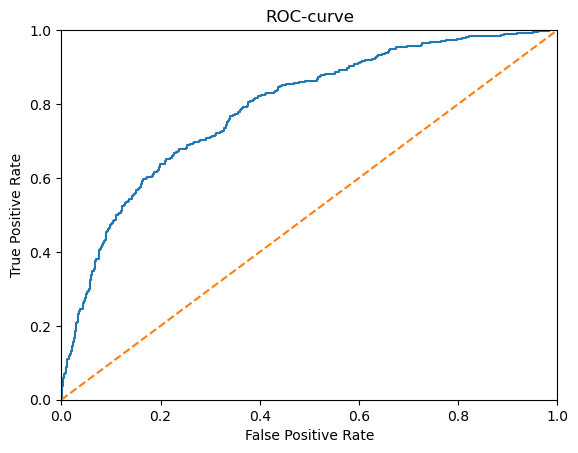

In [24]:
# prediction the probabilities of classifying an object as a class 1
probabilities_valid_lr_disb = model_log_regr_disb.predict_proba(features_valid)
probabilities_one_valid_lr_disb = probabilities_valid_lr_disb[:, 1]
# using the ROC curve function to determine the false positive rate, true positive rate and thresholds
fpr_lr_disb, tpr_lr_disb, thresholds_lr_disb = roc_curve(target_valid, probabilities_one_valid_lr_disb)
# creating a graph and passing it false positive rate and true positive rate
plt.figure()
plt.plot(fpr_lr_disb, tpr_lr_disb)
# we build a dotted line to indicate a random model
plt.plot([0, 1], [0, 1], linestyle='--')
# setting limits on x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# setting the names of the axes and the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
# show the plot
plt.show()

Calculating AUC-ROC

In [25]:
auc_roc_lr_disb = roc_auc_score(target_valid, probabilities_one_valid_lr_disb)
print(auc_roc_lr_disb)

0.7893010355098474


#### An unbalanced decision tree model

In [26]:
# We set a variable in which the best unbalanced decision tree model will be written
best_model_decision_tree_disb = None
# We set empty lists in which we will record the results of the evaluation by the F1 metric on the training and validation samples
results_train_decision_tree = []
results_valid_decision_tree = []
# Setting the initial value of the F1 metric
best_result_decision_tree_disb = 0
# We are creating a loop with which we will build decision trees with a maximum depth from 1 to 20
for depth in range(1, 21):
    # Creating a decision tree model with maximum depth according to the cycle
    model_decision_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    # We train the decision tree model on a training sample  
    model_decision_tree = model_decision_tree.fit(features_train, target_train)
    # Predicting classes based on a training sample
    predictions_train_decision_tree = model_decision_tree.predict(features_train)
    # Calculating the F1 metric for the training sample
    result_train_decision_tree = f1_score(target_train, predictions_train_decision_tree)
    # Adding the value F1 to the list  
    results_train_decision_tree.append(result_train_decision_tree)
    # Predicting classes based on a validation sample   
    predictions_valid_decision_tree = model_decision_tree.predict(features_valid)
    # Calculating the F1 metric for the validation sample
    result_valid_decision_tree = f1_score(target_valid, predictions_valid_decision_tree)
    # Adding the value F1 to the list   
    results_valid_decision_tree.append(result_valid_decision_tree)
    # We check whether the F1 metric in the validation sample is greater than the maximum one found earlier
    # If the new metric is larger, then we resave the new values instead of the previous ones
    if result_valid_decision_tree > best_result_decision_tree_disb:
        best_model_decision_tree_disb = model_decision_tree
        best_result_decision_tree_disb = result_valid_decision_tree
        best_depth_disb = depth
print("F1 of the best decision tree model:", best_result_decision_tree_disb)
print("The depth of the best decision tree model:", best_depth_disb)

F1 of the best decision tree model: 0.5862646566164155
The depth of the best decision tree model: 7


Creating a dataframe with the obtained F1 metrics on the training and validation samples

In [27]:
df_deс_tree_res = pd.DataFrame({'depth':np.arange(1, 21, 1), 'train': results_train_decision_tree, 'valid': results_valid_decision_tree}).set_index('depth')

Building learning curves for the decision tree

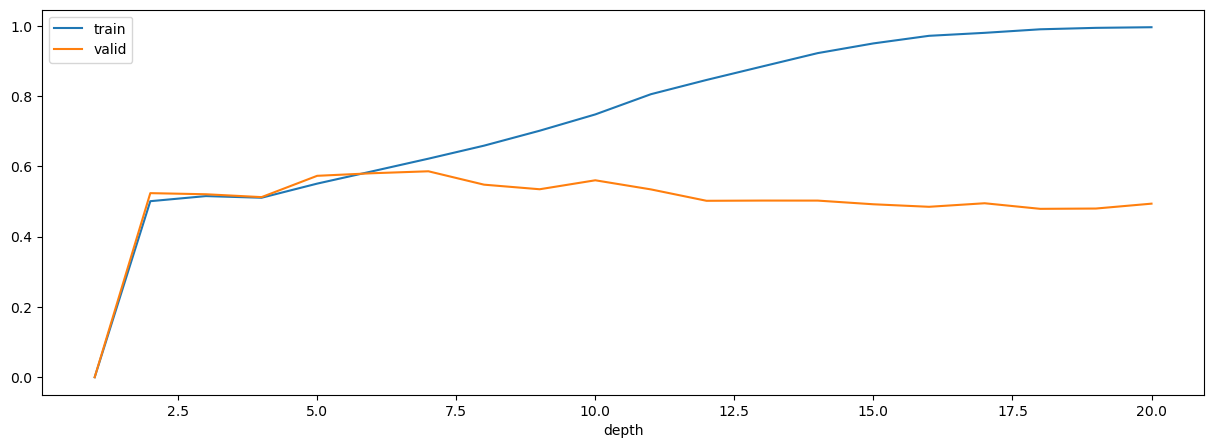

In [28]:
df_deс_tree_res.plot(figsize=(15, 5))
plt.show()

Let's display the first three levels of the best decision tree

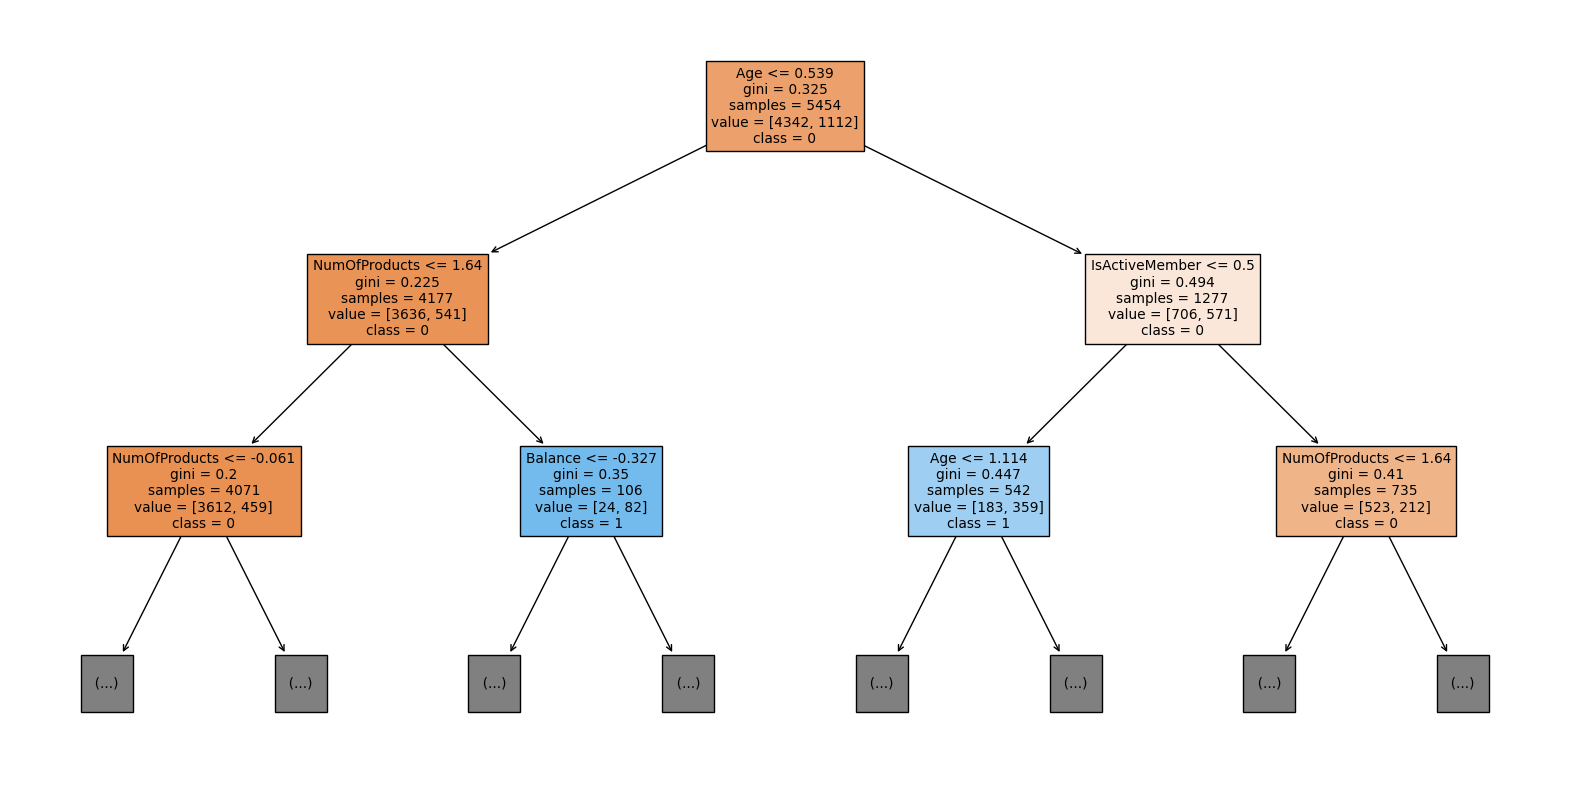

In [29]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(best_model_decision_tree_disb, 
                   feature_names=features_valid.columns,  
                   class_names=['0', '1'],
                   filled=True, max_depth=2)

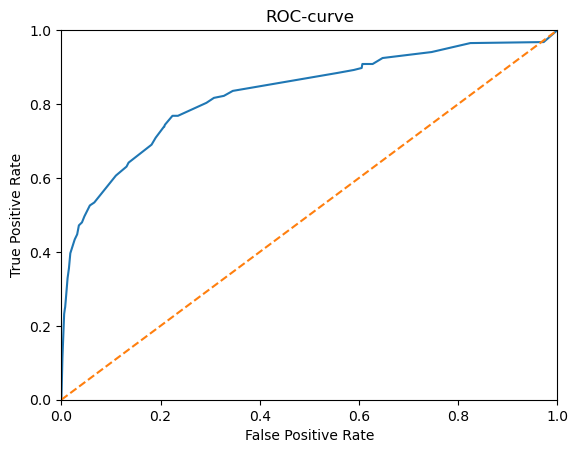

In [30]:
# predicting the probabilities of classifying an object as a class 1
probabilities_valid_dt_disb = best_model_decision_tree_disb.predict_proba(features_valid)
probabilities_one_valid_dt_disb = probabilities_valid_dt_disb[:, 1]
# using the ROC curve function to determine the false positive rate, true positive rate and thresholds
fpr_dt_disb, tpr_dt_disb, thresholds_dt_disb = roc_curve(target_valid, probabilities_one_valid_dt_disb)
# creating a graph and passing it false positive rate and true positive rate
plt.figure()
plt.plot(fpr_dt_disb, tpr_dt_disb)
# showing a dotted line to indicate a random model
plt.plot([0, 1], [0, 1], linestyle='--')
# setting limits on x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# setting the names of the axes and the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
# show the plot
plt.show()

Calculate AUC-ROC

In [31]:
auc_roc_dt_disb = roc_auc_score(target_valid, probabilities_one_valid_dt_disb)
print(auc_roc_dt_disb)

0.8273908095008354


#### A random forest model with an imbalance

Creating a dataframe in which we will record the result of learning the random forest model

In [32]:
df_random_forest_res = pd.DataFrame({'est':np.arange(1, 101, 1)})

Training and checking the F1 metric of a random forest

In [33]:
# Setting the variable in which the best model of a random forest with an imbalance will be written
best_model_random_forest_disb = None
# Setting the initial value of the F1 metric
best_result_random_forest_disb = 0
best_est_disb = 0
# Creating a cycle with which we will iterate through the maximum depth of random forest models from 1 to 20
# To control the time, add the tqdm function before the range
for max_depth_rf in tqdm(range(1, 21)):
    # Creating a column name for a previously created dataframe
    column_name_train = 'max_depth_' + str(max_depth_rf) + '_' + 'train'
    column_name_valid = 'max_depth_' + str(max_depth_rf) + '_' + 'valid'
    # Creating empty lists to record the results of the F1 metric in them for validation and training samples
    results_train_random_forest = []
    results_valid_random_forest = []
    # We are creating a loop with which we will iterate through the number of evaluators from 1 to 100
    for est in range(1, 101):
        # Creating a random forest model with hyperparameters according to cycles
        model_random_forest = RandomForestClassifier(n_estimators=est,
                                                     random_state=12345, 
                                                     max_depth=max_depth_rf)
        # We train the decision tree model on a training sample
        model_random_forest = model_random_forest.fit(features_train, 
                                                      target_train)
        # Predicting classes based on a training sample
        predictions_train_random_forest = model_random_forest.predict(features_train)
        # Counting the F1 metric for the training sample
        result_train_random_forest = f1_score(target_train, 
                                              predictions_train_random_forest)
        # Adding the value F1 to the list
        results_train_random_forest.append(result_train_random_forest)
        # Predicting classes based on a validation sample
        predictions_valid_random_forest = model_random_forest.predict(features_valid)
        # Calculating the F1 metric for the validation sample
        result_valid_random_forest = f1_score(target_valid, 
                                              predictions_valid_random_forest)
        # Adding the value F1 to the list
        results_valid_random_forest.append(result_valid_random_forest)
        # Checking whether the F1 metric in the validation sample is greater than the maximum one found earlier
        # If the new metric is larger, then we resave the new values instead of the previous ones
        if result_valid_random_forest > best_result_random_forest_disb:
            best_model_random_forest_disb = model_random_forest
            best_result_random_forest_disb = result_valid_random_forest
            best_est_disb = est
            best_depth_rf_disb = max_depth_rf
    # Transforming the lists into a Series
    df_random_forest_res[column_name_train] = pd.Series(results_train_random_forest)
    df_random_forest_res[column_name_valid] = pd.Series(results_valid_random_forest)
print("F1 of the best random forest model:", best_result_random_forest_disb)
print("The number of estimators of the best random forest model:", best_est_disb)
print("The best depth of the random forest model:", best_depth_rf_disb)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:44<00:00, 17.24s/it]

F1 of the best random forest model: 0.6263910969793324
The number of estimators of the best random forest model: 37
The best depth of the random forest model: 19


We set the column with the number of evaluators as the index. And we will print the first five lines

In [34]:
df_random_forest_res = df_random_forest_res.set_index('est')
df_random_forest_res.head()

max_depth_1_train  max_depth_1_valid  max_depth_2_train  \
est                                                            
1             0.242097           0.242991           0.242097   
2             0.242097           0.242991           0.177092   
3             0.000000           0.000000           0.064404   
4             0.000000           0.000000           0.136895   
5             0.000000           0.000000           0.121314   

     max_depth_2_valid  max_depth_3_train  max_depth_3_valid  \
est                                                            
1             0.242991           0.436603           0.478873   
2             0.176039           0.352688           0.366316   
3             0.067708           0.361111           0.382114   
4             0.149254           0.432032           0.477842   
5             0.130653           0.345324           0.402516   

     max_depth_4_train  max_depth_4_valid  max_depth_5_train  \
est                                                            
1             0.411338           0.423301           0.410498   
2             0.376140           0.385093           0.489032   
3             0.328707           0.343348           0.503153   
4             0.314774           0.321041           0.505689   
5             0.331387           0.340517           0.483344   

     max_depth_5_valid  ...  max_depth_16_train  max_depth_16_valid  \
est                     ...                                           
1             0.404000  ...            0.770169            0.522310   
2             0.527103  ...            0.770127            0.467662   
3             0.491803  ...            0.860068            0.579795   
4             0.492593  ...            0.858434            0.543333   
5             0.478011  ...            0.895349            0.575851   

     max_depth_17_train  max_depth_17_valid  max_depth_18_train  \
est                                                               
1              0.777424            0.503329            0.806937   
2              0.778903            0.475043            0.774573   
3              0.883523            0.556369            0.888038   
4              0.873267            0.503378            0.876740   
5              0.907010            0.559748            0.922642   

     max_depth_18_valid  max_depth_19_train  max_depth_19_valid  \
est                                                               
1              0.477490            0.794288            0.508906   
2              0.422794            0.773290            0.481416   
3              0.521472            0.899436            0.554572   
4              0.464865            0.875062            0.532203   
5              0.542857            0.925176            0.589147   

     max_depth_20_train  max_depth_20_valid  
est                                          
1              0.803044            0.500000  
2              0.770234            0.463822  
3              0.902462            0.553383  
4              0.873000            0.516579  
5              0.932521            0.570543  

[5 rows x 40 columns]

Let's output the learning curves

In [35]:
fig = go.Figure()
for i in df_random_forest_res.columns:
    fig.add_trace(go.Scatter(x=df_random_forest_res.index, y=df_random_forest_res[i],
                        mode='lines',
                        name=i))
#fig.add_vrect(x0=best_est, x1=best_est)
fig.show()

Creating another dataframe with the results of training a random forest model with various hyperparameters, but now we will use the maximum depth of the tree as the index

In [36]:
list_of_valid_accuracy = []
max_accuracy_on_depth_random_forest_valid = []
max_accuracy_on_depth_random_forest_train = []
for name in df_random_forest_res.columns:
    if 'valid' in name:
        list_of_valid_accuracy.append(name)
        max_accuracy_on_depth_random_forest_valid.append(df_random_forest_res[name].max())
    else:
        max_accuracy_on_depth_random_forest_train.append(df_random_forest_res[name].max())
df_random_forest_depth_accuracy = pd.DataFrame({'depth':np.arange(1, 21, 1), 'train_accuracy': pd.Series(max_accuracy_on_depth_random_forest_train), 'valid_accuracy': pd.Series(max_accuracy_on_depth_random_forest_valid)}).set_index('depth')

We will output learning curves depending on the maximum depth of the tree

In [37]:
fig = go.Figure()
for i in df_random_forest_depth_accuracy.columns:
    fig.add_trace(go.Scatter(x=df_random_forest_depth_accuracy.index, y=df_random_forest_depth_accuracy[i],
                        mode='lines',
                        name=i))
#fig.add_vrect(x0=best_est, x1=best_est)
fig.show()

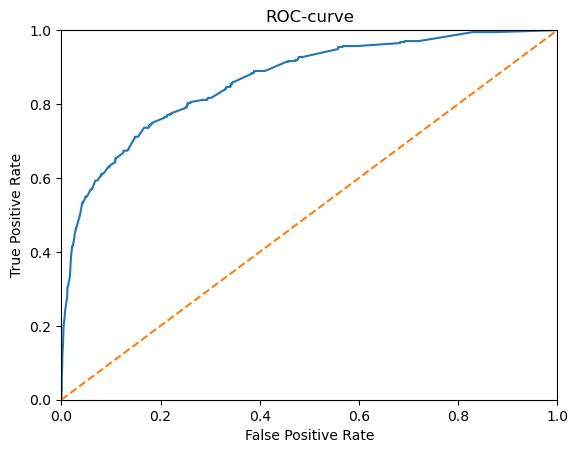

In [38]:
# predicting the probabilities of classifying an object as a class 1
probabilities_valid_rf_disb = best_model_random_forest_disb.predict_proba(features_valid)
probabilities_one_valid_rf_disb = probabilities_valid_rf_disb[:, 1]
# using the ROC curve function to determine the false positive rate, true positive rate and threshold
fpr_rf_disb, tpr_rf_disb, thresholds_rf_disb = roc_curve(target_valid, probabilities_one_valid_rf_disb)
# creating a graph and passing it false positive rate and true positive rate
plt.figure()
plt.plot(fpr_rf_disb, tpr_rf_disb)
# creating a dotted line to indicate a random model
plt.plot([0, 1], [0, 1], linestyle='--')
# setting limits on x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# setting the names of the axes and the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
# show the plot
plt.show()

Calculate ROC-AUC

In [39]:
auc_roc_rf_disb = roc_auc_score(target_valid, probabilities_one_valid_rf_disb)
print(auc_roc_rf_disb)

0.8635358591155229


In [40]:
print("F1 logistic regression models:", result_valid_log_regr_disb)
print("F1 of the best decision tree model:", best_result_decision_tree_disb)
print("F1 of the best random forest model:", best_result_random_forest_disb)

F1 logistic regression models: 0.3306772908366534
F1 of the best decision tree model: 0.5862646566164155
F1 of the best random forest model: 0.6263910969793324


As a result of testing various learning models using raw data without correcting the imbalance, it turned out that the most accurate model is the random forest model.

## Solving the imbalance problem

### Downsampling

As a method to combat the imbalance, we will first try to delete some of the data using the downsampling technique

Setting a function to reduce the selection

In [41]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Calculating how much of the data needs to be deleted in order to equalize the classes

In [42]:
fraction = 1 - (target_train.value_counts().max() - target_train.value_counts().min()) / target_train.value_counts().max()
fraction

0.25610317825886686

Using the downsample function on the training sample

In [43]:
features_train_down, target_train_down = downsample(features_train, target_train, fraction)

We check the shares of classes

In [44]:
target_train_down.value_counts(normalize=True)

1    0.5
0    0.5
Name: Exited, dtype: float64

We check the proportion of the training sample from the original dataframe

In [45]:
print('The size of the training sample:', features_train_down.shape[0] / features.shape[0])

The size of the training sample: 0.24463755362446377


The data has been prepared. We are ready to start training models

We will train models of logistic regression, decision tree, and random forest. Let's start with the logistic regression model. I will add down at the end of the name to indicate the downsampling method in this model

#### Logistic regression model

In [46]:
# creating a model
model_log_regr_down = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
# training the model
model_log_regr_down = model_log_regr_down.fit(features_train_down, target_train_down)
# predicting values from the training sample
predictions_train_log_regr_down = model_log_regr_down.predict(features_train_down)
# calculating the F1 metric on the training sample
result_train_log_regr_down = f1_score(predictions_train_log_regr_down, target_train_down)
print("F1 logistic regression models based on a training sample:", result_train_log_regr_down)
# predicting values from the validation sample
predictions_valid_log_regr_down = model_log_regr_down.predict(features_valid)
# calculating the F1 metric on the validation sample
result_valid_log_regr_down = f1_score(predictions_valid_log_regr_down, target_valid)
print("F1 logistic regression models based on a validation sample:", result_valid_log_regr_down)

F1 logistic regression models based on a training sample: 0.711634223630602
F1 logistic regression models based on a validation sample: 0.5144454799627214


As you can see, the F1 metric has grown compared to the model based on data with an imbalance

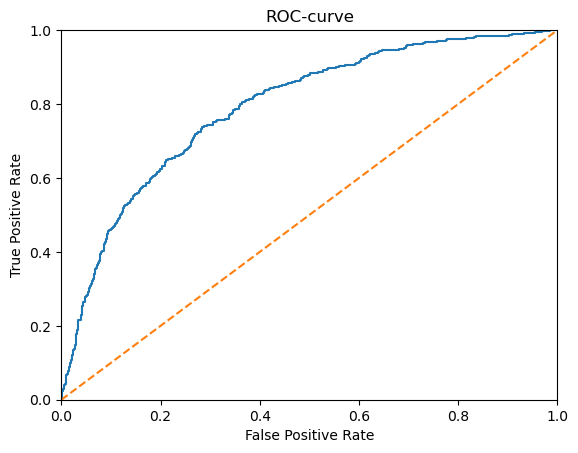

In [47]:
# predicting the probabilities of classifying an object as a class 1
probabilities_valid_lr_down = model_log_regr_down.predict_proba(features_valid)
probabilities_one_valid_lr_down = probabilities_valid_lr_down[:, 1]
# using the ROC curve function to determine the false positive rate, true positive rate and threshold
fpr_lr_down, tpr_lr_down, thresholds_lr_down = roc_curve(target_valid, probabilities_one_valid_lr_down)
# creating a graph and passing it false positive rate and true positive rate
plt.figure()
plt.plot(fpr_lr_down, tpr_lr_down)
# creating a dotted line to indicate a random model
plt.plot([0, 1], [0, 1], linestyle='--')
# setting limits on x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# setting the names of the axes and the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
# show the plot
plt.show()

Calculate ROC-AUC

In [48]:
auc_roc_lr_down = roc_auc_score(target_valid, probabilities_one_valid_lr_down)
print(auc_roc_lr_down)

0.7910725229445809


#### The decision tree model

Let's create a decision tree model

In [49]:
# Setting a variable in which the best downsampling decision tree model will be written
best_model_decision_tree_down = None
# We set empty lists in which we will record the results of the evaluation by the F1 metric on the training and validation samples
results_train_decision_tree_down = []
results_valid_decision_tree_down = []
# Setting the initial value of the F1 metric
best_result_decision_tree_down = 0
# We are creating a loop with which we will create decision trees with a maximum depth from 1 to 20
for depth in range(1, 21):
    # Creating a decision tree model with maximum depth according to the cycle
    model_decision_tree = DecisionTreeClassifier(random_state=12345, 
                                                 max_depth=depth)
    # We train the decision tree model on a training sample  
    model_decision_tree = model_decision_tree.fit(features_train_down,
                                                  target_train_down)
    # Predicting classes based on a training sample
    predictions_train_decision_tree = model_decision_tree.predict(features_train_down)
    # Counting the F1 metric for the training sample  
    result_train_decision_tree = f1_score(target_train_down,
                                          predictions_train_decision_tree)
    # Adding the value F1 to the list     
    results_train_decision_tree_down.append(result_train_decision_tree)
    # Predicting classes based on a validation sample
    predictions_valid_decision_tree = model_decision_tree.predict(features_valid)
    # We consider the F1 metric for the validation sample
    result_valid_decision_tree = f1_score(target_valid,
                                          predictions_valid_decision_tree)
    # Adding the value F1 to the list    
    results_valid_decision_tree_down.append(result_valid_decision_tree)
    # We check whether the F1 metric in the validation sample is greater than the maximum one found earlier
    # If the new metric is larger, then we resave the new values instead of the previous ones
    if result_valid_decision_tree > best_result_decision_tree_down:
        best_model_decision_tree_down = model_decision_tree
        best_result_decision_tree_down = result_valid_decision_tree
        best_depth_down = depth
print("F1 of the best decision tree model:", best_result_decision_tree_down)
print("The depth of the best decision tree model:", best_depth_down)

F1 of the best decision tree model: 0.5623721881390594
The depth of the best decision tree model: 4


Creating a dataframe with the results of the F1 check

In [50]:
df_deс_tree_res_down = pd.DataFrame({'depth':np.arange(1, 21, 1), 'train': results_train_decision_tree_down, 'valid': results_valid_decision_tree_down}).set_index('depth')

Let's display the learning curves on the graph

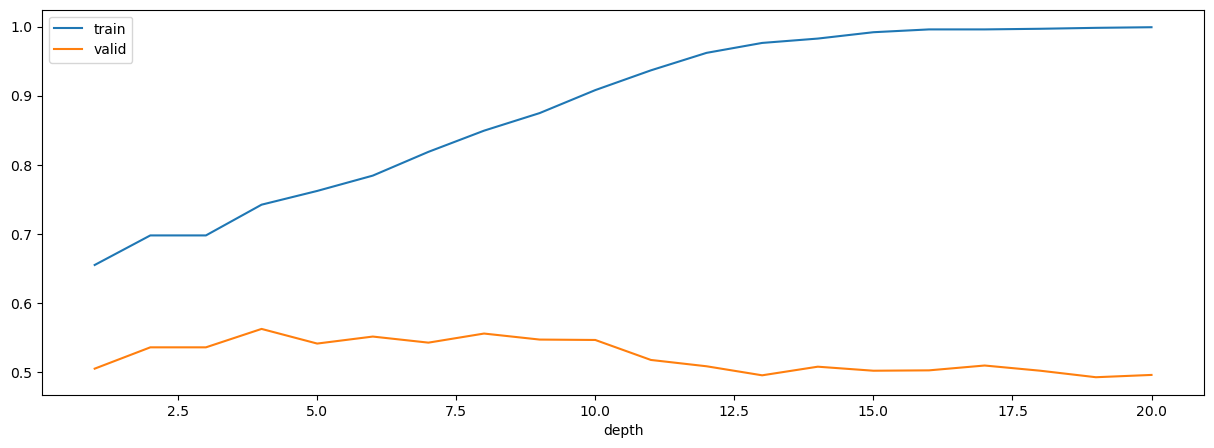

In [51]:
df_deс_tree_res_down.plot(figsize=(15, 5))
plt.show()

Show the decision tree to a depth of 3

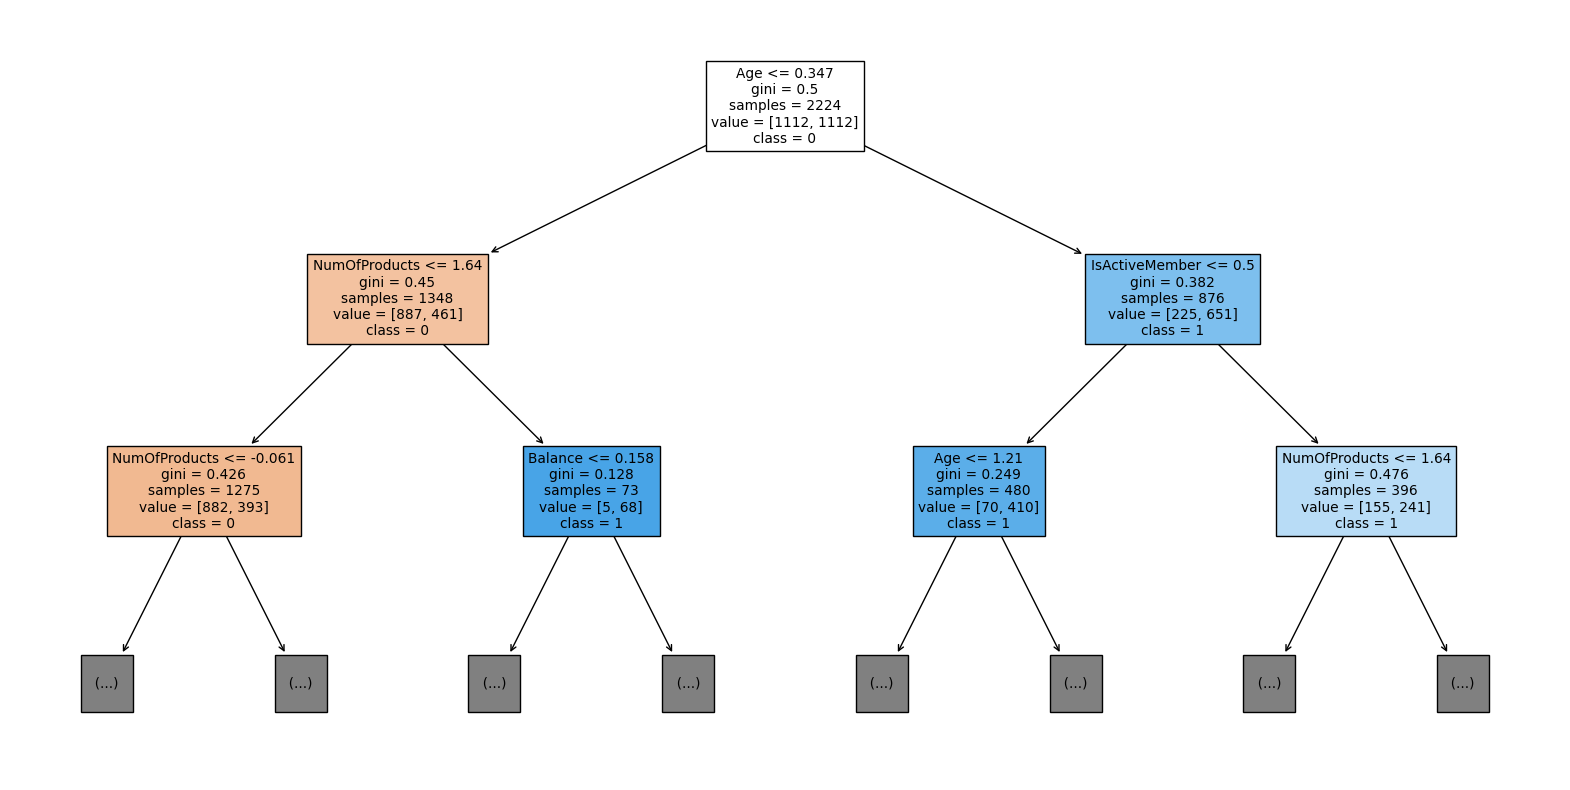

In [52]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(best_model_decision_tree_down, 
                   feature_names=features_valid.columns,  
                   class_names=['0', '1'],
                   filled=True, max_depth=2)

We are creating a dataframe in which we will record the result of learning the random forest model

In [53]:
df_random_forest_res_down = pd.DataFrame({'est':np.arange(1, 101, 1)})

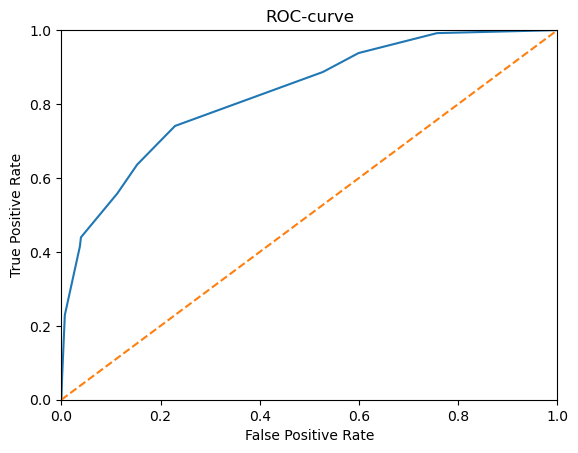

In [54]:
# predicting the probabilities of classifying an object as a class 1
probabilities_valid_dt_down = best_model_decision_tree_down.predict_proba(features_valid)
probabilities_one_valid_dt_down = probabilities_valid_dt_down[:, 1]
# using the ROC curve function to determine the false positive rate, true positive rate and threshold
fpr_dt_down, tpr_dt_down, thresholds_dt_down = roc_curve(target_valid, probabilities_one_valid_dt_down)
# creating a graph and passing it false positive rate and true positive rate
plt.figure()
plt.plot(fpr_dt_down, tpr_dt_down)
# creating a dotted line to indicate a random model
plt.plot([0, 1], [0, 1], linestyle='--')
# setting limits on x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# setting the names of the axes and the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
# show the plot
plt.show()

Calculate ROC-AUC

In [55]:
auc_roc_dt_down = roc_auc_score(target_valid, probabilities_one_valid_dt_down)
print(auc_roc_dt_down)

0.827097424357859


#### The random forest model

Let's build a random forest model

In [56]:
# Setting the variable in which the best model of a random forest with downsampling will be written
best_model_random_forest_down = None
# Setting the initial value of the F1 metric
best_result_random_forest_down = 0
best_est_down = 0
# Creating a cycle with which we will iterate through the maximum depth of random forest models from 1 to 20
# To control the time, add the tqdm function before the range
for max_depth_rf in tqdm(range(1, 21)):
    # Creating a column name for a previously created dataframe
    column_name_train = 'max_depth_' + str(max_depth_rf) + '_' + 'train'
    column_name_valid = 'max_depth_' + str(max_depth_rf) + '_' + 'valid'
    # Creating empty lists to record the results of the F1 metric in them for validation and training samples
    results_train_random_forest_down = []
    results_valid_random_forest_down = []
    # Creating a loop with which we will iterate through the number of evaluators from 1 to 100
    for est in range(1, 101):
        # Creating a random forest model with hyperparameters according to cycles
        model_random_forest = RandomForestClassifier(n_estimators=est, random_state=12345, 
                                                     max_depth=max_depth_rf)
        # We train the decision tree model on a training sample
        model_random_forest = model_random_forest.fit(features_train_down, 
                                                      target_train_down)
        # Predicting classes based on a training sample
        predictions_train_random_forest = model_random_forest.predict(features_train_down)
        # Counting the F1 metric for the training sample
        result_train_random_forest = f1_score(target_train_down, 
                                              predictions_train_random_forest)
        # Adding the value F1 to the list
        results_train_random_forest_down.append(result_train_random_forest)
        # Predicting classes based on a validation sample
        predictions_valid_random_forest = model_random_forest.predict(features_valid)
        # We consider the F1 metric for the validation sample
        result_valid_random_forest = f1_score(target_valid, 
                                              predictions_valid_random_forest)
        # Adding the value F1 to the list
        results_valid_random_forest_down.append(result_valid_random_forest)
        # We check whether the F1 metric in the validation sample is greater than the maximum one found earlier
        # If the new metric is larger, then we resave the new values instead of the previous ones
        if result_valid_random_forest > best_result_random_forest_down:
            best_model_random_forest_down = model_random_forest
            best_result_random_forest_down = result_valid_random_forest
            best_est_down = est
            best_depth_rf_down = max_depth_rf
    # transforming the lists into a Series
    df_random_forest_res_down[column_name_train] = pd.Series(results_train_random_forest_down)
    df_random_forest_res_down[column_name_valid] = pd.Series(results_valid_random_forest_down)
print("F1 of the best random forest model:", best_result_random_forest_down)
print("The number of evaluators of the best random forest model:", best_est_down)
print("The best depth of the random forest model:", best_depth_rf_down)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:10<00:00,  9.52s/it]

F1 of the best random forest model: 0.6222222222222222
The number of evaluators of the best random forest model: 26
The best depth of the random forest model: 19


Setting the est column as the index. Let's print the first 5 lines

In [57]:
df_random_forest_res_down = df_random_forest_res_down.set_index('est')
df_random_forest_res_down.head()

max_depth_1_train  max_depth_1_valid  max_depth_2_train  \
est                                                            
1             0.644891           0.385432           0.644891   
2             0.678760           0.394495           0.648598   
3             0.486486           0.380615           0.698158   
4             0.661743           0.517094           0.716472   
5             0.693730           0.505107           0.725254   

     max_depth_2_valid  max_depth_3_train  max_depth_3_valid  \
est                                                            
1             0.385432           0.600100           0.448811   
2             0.478261           0.667014           0.540163   
3             0.513889           0.694789           0.558242   
4             0.518315           0.733365           0.573484   
5             0.545988           0.736842           0.579111   

     max_depth_4_train  max_depth_4_valid  max_depth_5_train  \
est                                                            
1             0.702351           0.568233           0.713100   
2             0.708458           0.569857           0.736695   
3             0.744165           0.549708           0.756121   
4             0.756310           0.572835           0.777574   
5             0.753991           0.601036           0.783372   

     max_depth_5_valid  ...  max_depth_16_train  max_depth_16_valid  \
est                     ...                                           
1             0.464666  ...            0.880464            0.481793   
2             0.531440  ...            0.874753            0.514066   
3             0.548523  ...            0.945291            0.518804   
4             0.557377  ...            0.938433            0.541524   
5             0.572641  ...            0.972097            0.541627   

     max_depth_17_train  max_depth_17_valid  max_depth_18_train  \
est                                                               
1              0.882458            0.474545            0.882458   
2              0.873767            0.480392            0.864945   
3              0.937082            0.513744            0.942601   
4              0.941779            0.533333            0.938144   
5              0.968468            0.531549            0.968061   

     max_depth_18_valid  max_depth_19_train  max_depth_19_valid  \
est                                                               
1              0.474545            0.882458            0.474545   
2              0.481203            0.881921            0.511166   
3              0.515094            0.941652            0.528302   
4              0.548315            0.940682            0.568182   
5              0.532692            0.969397            0.551060   

     max_depth_20_train  max_depth_20_valid  
est                                          
1              0.882458            0.474545  
2              0.872047            0.479012  
3              0.937444            0.498620  
4              0.942272            0.534231  
5              0.968004            0.529081  

[5 rows x 40 columns]

Displaying learning curves depending on the number of estimators

In [58]:
fig = go.Figure()
for i in df_random_forest_res_down.columns:
    fig.add_trace(go.Scatter(x=df_random_forest_res_down.index, y=df_random_forest_res_down[i],
                        mode='lines',
                        name=i))
#fig.add_vrect(x0=best_est, x1=best_est)
fig.show()

Let's create another dataframe with the results of training a random forest model with various hyperparameters, but now we will use the maximum depth of the tree as the index

In [59]:
list_of_valid_accuracy = []
max_accuracy_on_depth_random_forest_valid = []
max_accuracy_on_depth_random_forest_train = []
for name in df_random_forest_res_down.columns:
    if 'valid' in name:
        list_of_valid_accuracy.append(name)
        max_accuracy_on_depth_random_forest_valid.append(df_random_forest_res_down[name].max())
    else:
        max_accuracy_on_depth_random_forest_train.append(df_random_forest_res_down[name].max())
df_random_forest_depth_accuracy_down = pd.DataFrame({'depth':np.arange(1, 21, 1), 'train_accuracy': pd.Series(max_accuracy_on_depth_random_forest_train), 'valid_accuracy': pd.Series(max_accuracy_on_depth_random_forest_valid)}).set_index('depth')

We will output learning curves depending on the maximum depth of the tree

In [60]:
fig = go.Figure()
for i in df_random_forest_depth_accuracy_down.columns:
    fig.add_trace(go.Scatter(x=df_random_forest_depth_accuracy_down.index, y=df_random_forest_depth_accuracy_down[i],
                        mode='lines',
                        name=i))
fig.add_vrect(x0=best_depth_rf_down, x1=best_depth_rf_down)
fig.show()

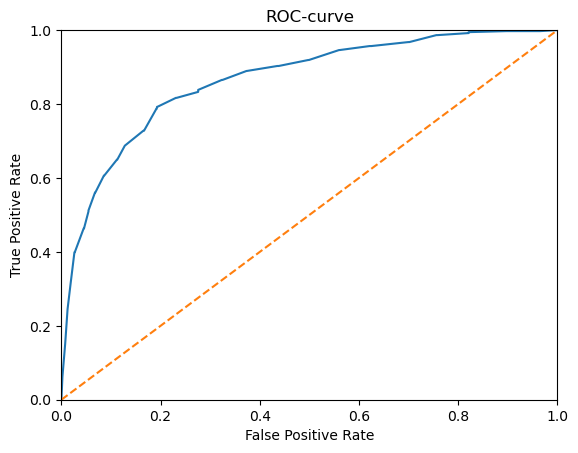

In [61]:
# predicting the probabilities of classifying an object as a class 1
probabilities_valid_rf_down = best_model_random_forest_down.predict_proba(features_valid)
probabilities_one_valid_rf_down = probabilities_valid_rf_down[:, 1]
# using the ROC curve function to determine the false positive rate, true positive rate and threshold
fpr_rf_down, tpr_rf_down, thresholds_rf_down = roc_curve(target_valid, probabilities_one_valid_rf_down)
# creating a graph and passing it false positive rate and true positive rate
plt.figure()
plt.plot(fpr_rf_down, tpr_rf_down)
# creating a dotted line to indicate a random model
plt.plot([0, 1], [0, 1], linestyle='--')
# setting limits on x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# setting the names of the axes and the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
# show the plot
plt.show()

Calculate ROC-AUC

In [62]:
auc_roc_rf_down = roc_auc_score(target_valid, probabilities_one_valid_rf_down)
print(auc_roc_rf_down)

0.8646712130497711


### Upsampling

Setting a function to increase the selection

In [63]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

We determine how many times it is necessary to increase the number of rows with class 1

In [64]:
fraction = int(round((target_train.value_counts().max()) / target_train.value_counts().min(), 0))
fraction

4

In [65]:
features_train_up, target_train_up = upsample(features_train, target_train, fraction)

Checking the class ratio

In [66]:
target_train_up.value_counts(normalize=True)

1    0.50603
0    0.49397
Name: Exited, dtype: float64

We check the proportion of the training sample from the original dataframe

In [67]:
print('The size of the training sample:', features_train_down.shape[0] / features.shape[0])

The size of the training sample: 0.24463755362446377


The data has been prepared. We can start training models

We will train models of logistic regression, decision tree, and random forest. Let's start with the logistic regression model. I will add down at the end of the name to indicate the downsampling method in this model

#### Logistic regression model

In [68]:
# creating a model
model_log_regr_up = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
# training the model
model_log_regr_up = model_log_regr_up.fit(features_train_up, target_train_up)
# predicting values from the training sample
predictions_train_log_regr_up = model_log_regr_up.predict(features_train_up)
# calculating the F1 metric on the training sample
result_train_log_regr_up = f1_score(predictions_train_log_regr_up, target_train_up)
print("F1 logistic regression models based on a training sample:", result_train_log_regr_up)
# predicting values from the validation sample
predictions_valid_log_regr_up = model_log_regr_up.predict(features_valid)
# calculating the F1 metric on the validation sample
result_valid_log_regr_up = f1_score(predictions_valid_log_regr_up, target_valid)
print("F1 logistic regression models based on a validation sample:", result_valid_log_regr_up)

F1 logistic regression models based on a training sample: 0.7048418188003175
F1 logistic regression models based on a validation sample: 0.5065420560747663


As you can see, the F1 metric has grown compared to the model based on data with an imbalance, but it does not differ much from the model with downsapling

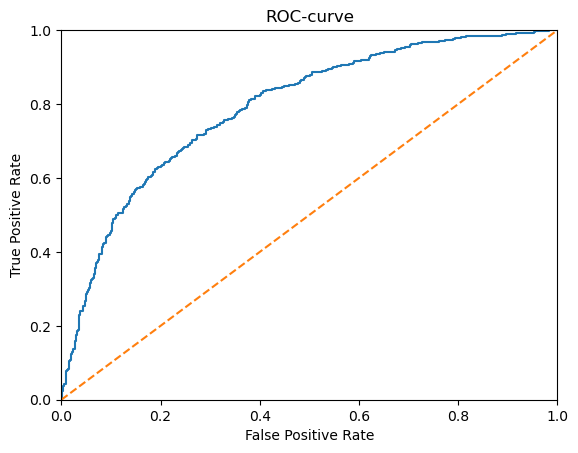

In [69]:
# predicting the probabilities of classifying an object as a class 1
probabilities_valid_lr_up = model_log_regr_up.predict_proba(features_valid)
probabilities_one_valid_lr_up = probabilities_valid_lr_up[:, 1]
# using the ROC curve function to determine the false positive rate, true positive rate and threshold
fpr_lr_up, tpr_lr_up, thresholds_lr_up = roc_curve(target_valid, probabilities_one_valid_lr_up)
# creating a graph and passing it false positive rate and true positive rate
plt.figure()
plt.plot(fpr_lr_up, tpr_lr_up)
# creating a dotted line to indicate a random model
plt.plot([0, 1], [0, 1], linestyle='--')
# setting limits on x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# setting the names of the axes and the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
# show the plot
plt.show()

Calculate ROC-AUC

In [70]:
auc_roc_lr_up = roc_auc_score(target_valid, probabilities_one_valid_lr_up)
print(auc_roc_lr_up)

0.790763304317698


#### The decision tree model

In [71]:
# Setting the variable to which the best upsampling decision tree model will be written
best_model_decision_tree_up = None
# We set empty lists in which we will record the results of the evaluation by the F1 metric on the training and validation samples
results_train_decision_tree_up = []
results_valid_decision_tree_up = []
# Setting the initial value of the F1 metric
best_result_decision_tree_up = 0
# We are creating a loop with which we will create decision trees with a maximum depth from 1 to 20
for depth in range(1, 21):
    # Creating a decision tree model with maximum depth according to the cycle
    model_decision_tree = DecisionTreeClassifier(random_state=12345, 
                                                 max_depth=depth)
    # We train the decision tree model on a training sample   
    model_decision_tree = model_decision_tree.fit(features_train_up,
                                                  target_train_up)
    # Predicting classes based on a training sample
    predictions_train_decision_tree = model_decision_tree.predict(features_train_up)
    # Counting the F1 metric for the training sample
    result_train_decision_tree = f1_score(target_train_up,
                                          predictions_train_decision_tree)
    # Adding the value F1 to the list
    results_train_decision_tree_up.append(result_train_decision_tree)
    # Predicting classes based on a validation sample
    predictions_valid_decision_tree = model_decision_tree.predict(features_valid)
    # We consider the F1 metric for the validation sample
    result_valid_decision_tree = f1_score(target_valid,
                                          predictions_valid_decision_tree)
    # Adding the value F1 to the list
    results_valid_decision_tree_up.append(result_valid_decision_tree)
    # We check whether the F1 metric in the validation sample is greater than the maximum one found earlier
    # If the new metric is larger, then we resave the new values instead of the previous ones
    if result_valid_decision_tree > best_result_decision_tree_up:
        best_model_decision_tree_up = model_decision_tree
        best_result_decision_tree_up = result_valid_decision_tree
        best_depth_up = depth
print("F1 of the best decision tree model:", best_result_decision_tree_up)
print("The depth of the best decision tree model:", best_depth_up)

F1 of the best decision tree model: 0.583084577114428
The depth of the best decision tree model: 6


Creating a dataframe with the results of the F1 check

In [72]:
df_deс_tree_res_up = pd.DataFrame({'depth':np.arange(1, 21, 1), 'train': results_train_decision_tree_up, 'valid': results_valid_decision_tree_up}).set_index('depth')

Let's display the learning curves on the graph

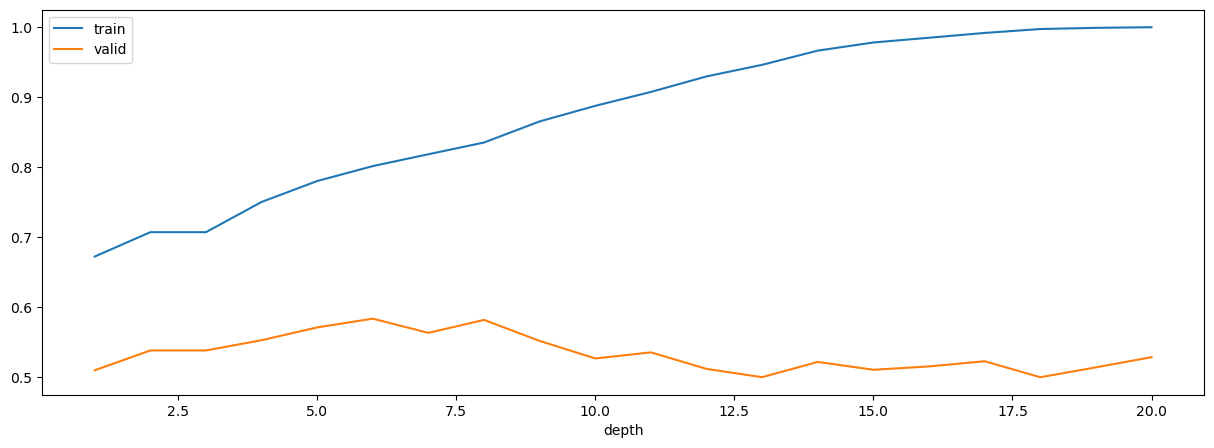

In [73]:
df_deс_tree_res_up.plot(figsize=(15, 5))
plt.show()

Show the decision tree to a depth of 3

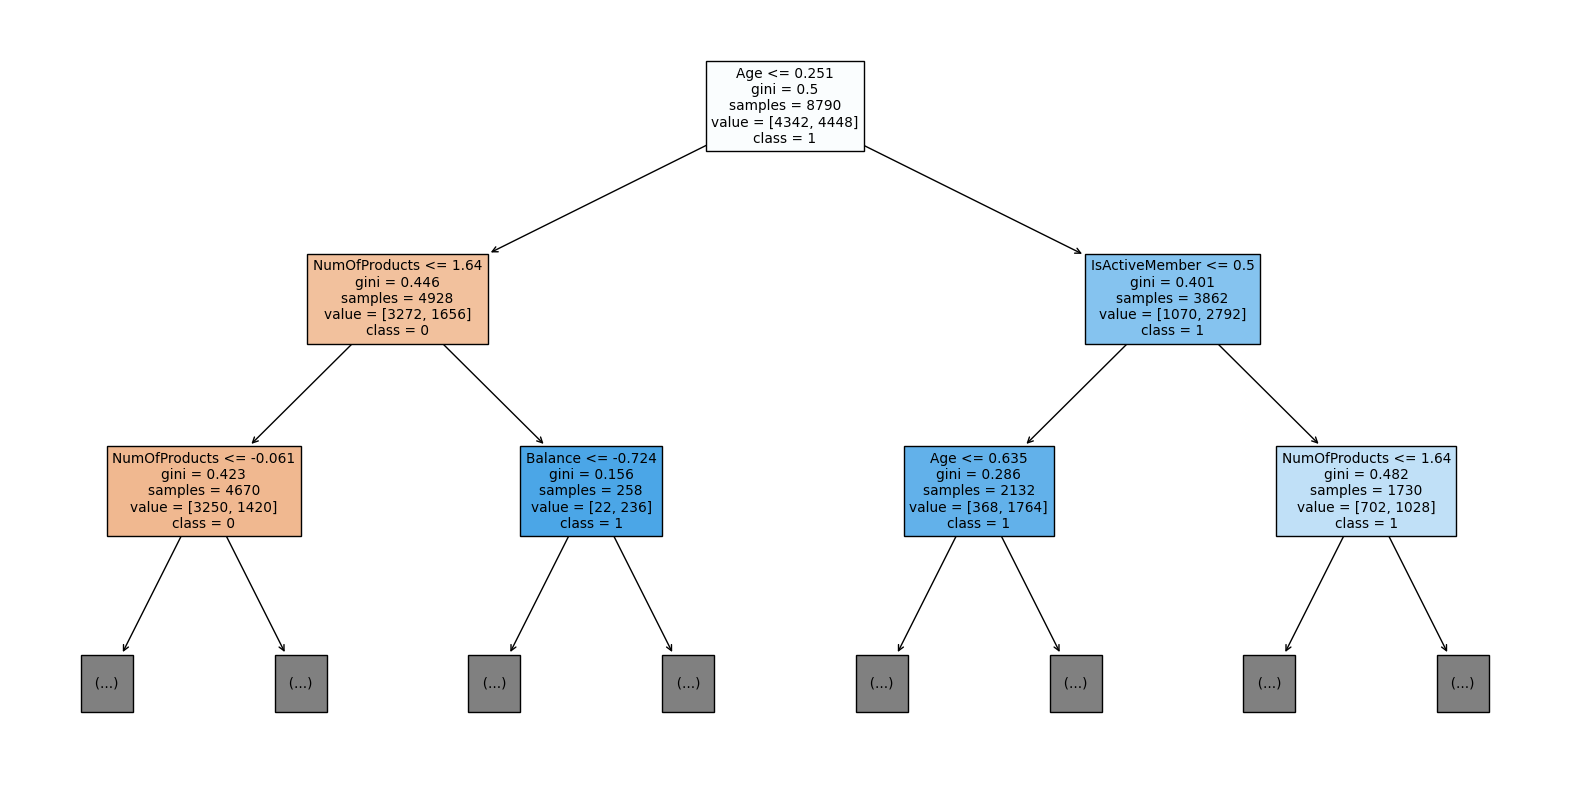

In [74]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(best_model_decision_tree_up, 
                   feature_names=features_valid.columns,  
                   class_names=['0', '1'],
                   filled=True, max_depth=2)

We are creating a dataframe in which we will record the result of learning the random forest model

In [75]:
df_random_forest_res_up = pd.DataFrame({'est':np.arange(1, 101, 1)})

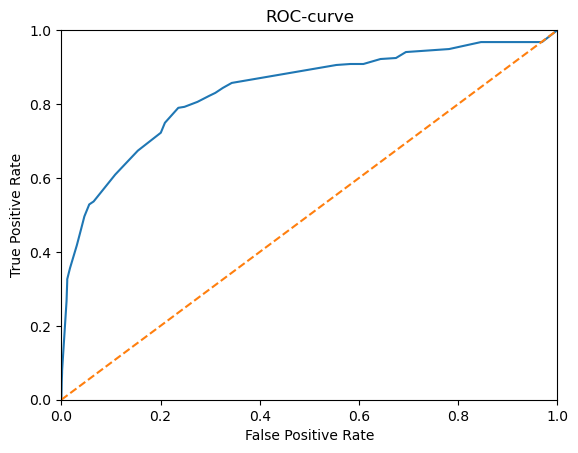

In [76]:
# predicting the probabilities of classifying an object as a class 1
probabilities_valid_dt_up = best_model_decision_tree_up.predict_proba(features_valid)
probabilities_one_valid_dt_up = probabilities_valid_dt_up[:, 1]
# using the ROC curve function to determine the false positive rate, true positive rate and threshold
fpr_dt_up, tpr_dt_up, thresholds_dt_up = roc_curve(target_valid, probabilities_one_valid_dt_up)
# creating a graph and passing it false positive rate and true positive rate
plt.figure()
plt.plot(fpr_dt_up, tpr_dt_up)
# creating a dotted line to indicate a random model
plt.plot([0, 1], [0, 1], linestyle='--')
# setting limits on x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# setting the names of the axes and the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
# show the plot
plt.show()

Calculate ROC-AUC

In [77]:
auc_roc_dt_up = roc_auc_score(target_valid, probabilities_one_valid_dt_up)
print(auc_roc_dt_up)

0.8353671598641673


#### The random forest model

In [78]:
# Setting the variable in which the best model of a random forest with downsampling will be written
best_model_random_forest_up = None
# Setting the initial value of the F1 metric
best_result_random_forest_up = 0
best_est_up = 0
# Creating a cycle with which we will iterate through the maximum depth of random forest models from 1 to 20
# To control the time, add the tqdm function before the range
for max_depth_rf in tqdm(range(1, 21)):
    # Creating a column name for a previously created dataframe
    column_name_train = 'max_depth_' + str(max_depth_rf) + '_' + 'train'
    column_name_valid = 'max_depth_' + str(max_depth_rf) + '_' + 'valid'
    # Creating empty lists to record the results of the F1 metric in them for validation and training samples
    results_train_random_forest_up = []
    results_valid_random_forest_up = []
    # Creating a loop with which we will iterate through the number of evaluators from 1 to 100
    for est in range(1, 101):
        # Creating a random forest model with hyperparameters according to cycles
        model_random_forest = RandomForestClassifier(n_estimators=est, random_state=12345, 
                                                     max_depth=max_depth_rf)
        # We train the decision tree model on a training sample
        model_random_forest = model_random_forest.fit(features_train_up, 
                                                      target_train_up)
        # Predicting classes based on a training sample
        predictions_train_random_forest = model_random_forest.predict(features_train_up)
        # Counting the F1 metric for the training sample
        result_train_random_forest = f1_score(target_train_up, 
                                              predictions_train_random_forest)
        # Adding the value F1 to the list
        results_train_random_forest_up.append(result_train_random_forest)
        # Predicting classes based on a validation sample
        predictions_valid_random_forest = model_random_forest.predict(features_valid)
        # We consider the F1 metric for the validation sample
        result_valid_random_forest = f1_score(target_valid, 
                                              predictions_valid_random_forest)
        # Adding the value F1 to the list
        results_valid_random_forest_up.append(result_valid_random_forest)
        # We check whether the F1 metric in the validation sample is greater than the maximum one found earlier
        # If the new metric is larger, then we resave the new values instead of the previous ones
        if result_valid_random_forest > best_result_random_forest_up:
            best_model_random_forest_up = model_random_forest
            best_result_random_forest_up = result_valid_random_forest
            best_est_up = est
            best_depth_rf_up = max_depth_rf
    # transforming the lists into a Series
    df_random_forest_res_up[column_name_train] = pd.Series(results_train_random_forest_up)
    df_random_forest_res_up[column_name_valid] = pd.Series(results_valid_random_forest_up)
print("F1 of the best random forest model:", best_result_random_forest_up)
print("The number of evaluators of the best random forest model:", best_est_up)
print("The best depth of the random forest model:", best_depth_rf_up)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:13<00:00, 24.67s/it]

F1 of the best random forest model: 0.648989898989899
The number of evaluators of the best random forest model: 81
The best depth of the random forest model: 11


Let's set the est column as the index. Let's print the first 5 lines

In [79]:
df_random_forest_res_up = df_random_forest_res_up.set_index('est')
df_random_forest_res_up.head()

max_depth_1_train  max_depth_1_valid  max_depth_2_train  \
est                                                            
1             0.246082           0.242991           0.559180   
2             0.559180           0.437642           0.559180   
3             0.644204           0.419405           0.688480   
4             0.722012           0.524201           0.687351   
5             0.715706           0.544191           0.671690   

     max_depth_2_valid  max_depth_3_train  max_depth_3_valid  \
est                                                            
1             0.437642           0.492089           0.487136   
2             0.437642           0.705290           0.569460   
3             0.541712           0.704658           0.574096   
4             0.584856           0.684837           0.594458   
5             0.581579           0.707227           0.575829   

     max_depth_4_train  max_depth_4_valid  max_depth_5_train  \
est                                                            
1             0.684806           0.510814           0.688533   
2             0.695153           0.517986           0.717729   
3             0.697466           0.539615           0.718120   
4             0.726027           0.569460           0.742072   
5             0.743534           0.585635           0.743701   

     max_depth_5_valid  ...  max_depth_16_train  max_depth_16_valid  \
est                     ...                                           
1             0.558789  ...            0.945852            0.496583   
2             0.584217  ...            0.980471            0.471810   
3             0.597015  ...            0.980496            0.542079   
4             0.591017  ...            0.992955            0.530259   
5             0.593897  ...            0.989856            0.584299   

     max_depth_17_train  max_depth_17_valid  max_depth_18_train  \
est                                                               
1              0.956008            0.529201            0.961749   
2              0.982994            0.475410            0.986598   
3              0.985327            0.556291            0.987775   
4              0.995966            0.536434            0.995739   
5              0.993522            0.594005            0.994300   

     max_depth_18_valid  max_depth_19_train  max_depth_19_valid  \
est                                                               
1              0.505338            0.964161            0.489845   
2              0.500803            0.987265            0.472131   
3              0.554090            0.987105            0.536965   
4              0.538103            0.996748            0.544892   
5              0.565517            0.994189            0.580991   

     max_depth_20_train  max_depth_20_valid  
est                                          
1              0.966226            0.504242  
2              0.988724            0.474465  
3              0.988214            0.545939  
4              0.996636            0.558779  
5              0.994856            0.577657  

[5 rows x 40 columns]

We display learning curves depending on the number of evaluators

In [80]:
fig = go.Figure()
for i in df_random_forest_res_up.columns:
    fig.add_trace(go.Scatter(x=df_random_forest_res_up.index, y=df_random_forest_res_up[i],
                        mode='lines',
                        name=i))
#fig.add_vrect(x0=best_est, x1=best_est)
fig.show()

Let's create another dataframe with the results of training a random forest model with various hyperparameters, but now we will use the maximum depth of the tree as the index

In [81]:
list_of_valid_accuracy = []
max_accuracy_on_depth_random_forest_valid = []
max_accuracy_on_depth_random_forest_train = []
for name in df_random_forest_res_up.columns:
    if 'valid' in name:
        list_of_valid_accuracy.append(name)
        max_accuracy_on_depth_random_forest_valid.append(df_random_forest_res_up[name].max())
    else:
        max_accuracy_on_depth_random_forest_train.append(df_random_forest_res_up[name].max())
df_random_forest_depth_accuracy_up = pd.DataFrame({'depth':np.arange(1, 21, 1), 'train_accuracy': pd.Series(max_accuracy_on_depth_random_forest_train), 'valid_accuracy': pd.Series(max_accuracy_on_depth_random_forest_valid)}).set_index('depth')

We will output learning curves depending on the maximum depth of the tree

In [82]:
fig = go.Figure()
for i in df_random_forest_depth_accuracy_up.columns:
    fig.add_trace(go.Scatter(x=df_random_forest_depth_accuracy_up.index, y=df_random_forest_depth_accuracy_up[i],
                        mode='lines',
                        name=i))
fig.add_vrect(x0=best_depth_rf_up, x1=best_depth_rf_up)
fig.show()

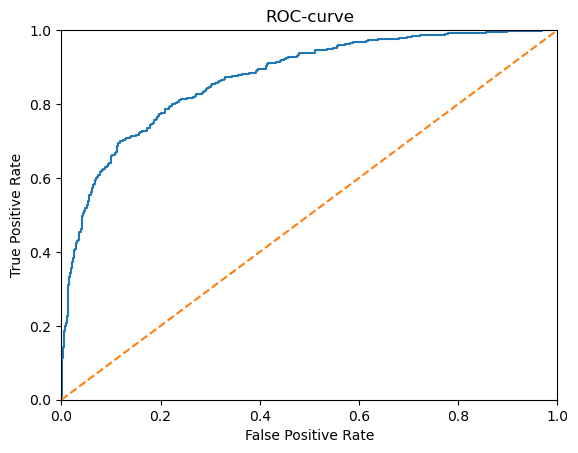

In [83]:
# predicting the probabilities of classifying an object as a class 1
probabilities_valid_rf_up = best_model_random_forest_up.predict_proba(features_valid)
probabilities_one_valid_rf_up = probabilities_valid_rf_up[:, 1]
# using the ROC curve function to determine the false positive rate, true positive rate and threshold
fpr_rf_up, tpr_rf_up, thresholds_rf_up = roc_curve(target_valid, probabilities_one_valid_rf_up)
# creating a graph and passing it false positive rate and true positive rate
plt.figure()
plt.plot(fpr_rf_up, tpr_rf_up)
# creating a dotted line to indicate a random model
plt.plot([0, 1], [0, 1], linestyle='--')
# setting limits on x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# setting the names of the axes and the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
# show the plot
plt.show()

Calculate ROC-AUC

In [84]:
auc_roc_rf_up = roc_auc_score(target_valid, probabilities_one_valid_rf_up)
print(auc_roc_rf_up)

0.8705771025469555


### Let's output the results of the model study and choose the best one for testing

#### Let's output the F1 metrics for each model

In [85]:
print("F1 logistic regression models with imbalance:", result_valid_log_regr_disb)
print("F1 of the best unbalanced decision tree model:", best_result_decision_tree_disb)
print("F1 of the best model of a random forest with an imbalance:", best_result_random_forest_disb)

F1 logistic regression models with imbalance: 0.3306772908366534
F1 of the best unbalanced decision tree model: 0.5862646566164155
F1 of the best model of a random forest with an imbalance: 0.6263910969793324


In [86]:
print("F1 logistic regression models with downsampling:", result_valid_log_regr_down)
print("F1 of the best decision tree model with downsampling:", best_result_decision_tree_down)
print("F1 of the best random forest model with downsampling:", best_result_random_forest_down)

F1 logistic regression models with downsampling: 0.5144454799627214
F1 of the best decision tree model with downsampling: 0.5623721881390594
F1 of the best random forest model with downsampling: 0.6222222222222222


In [87]:
print("F1 logistic regression models with upsampling:", result_valid_log_regr_up)
print("F1 of the best decision tree model with upsampling:", best_result_decision_tree_up)
print("F1 of the best random forest model with upsampling:", best_result_random_forest_up)

F1 logistic regression models with upsampling: 0.5065420560747663
F1 of the best decision tree model with upsampling: 0.583084577114428
F1 of the best random forest model with upsampling: 0.648989898989899


#### Let's output the AUC-ROC metrics for each model

In [89]:
print("AUC-ROC of the logistic regression model with imbalance:", auc_roc_lr_disb)
print("AUC-ROC of the best decision tree model with imbalance:", auc_roc_dt_disb)
print("AUC-ROC of the best random forest model with imbalance:", auc_roc_rf_disb)

AUC-ROC of the logistic regression model with imbalance: 0.7893010355098474
AUC-ROC of the best decision tree model with imbalance: 0.8273908095008354
AUC-ROC of the best random forest model with imbalance: 0.8635358591155229


In [90]:
print("AUC-ROC of the logistic regression model with downsampling:", auc_roc_lr_down)
print("AUC-ROC of the best decision tree model with downsampling:", auc_roc_dt_down)
print("AUC-ROC of the best random forest model with downsampling:", auc_roc_rf_down)

AUC-ROC of the logistic regression model with downsampling: 0.7910725229445809
AUC-ROC of the best decision tree model with downsampling: 0.827097424357859
AUC-ROC of the best random forest model with downsampling: 0.8646712130497711


In [91]:
print("AUC-ROC of the logistic regression model with upsampling:", auc_roc_lr_up)
print("AUC-ROC of the best decision tree model with upsampling:", auc_roc_dt_up)
print("AUC-ROC of the best random forest model with upsampling:", auc_roc_rf_up)

AUC-ROC of the logistic regression model with upsampling: 0.790763304317698
AUC-ROC of the best decision tree model with upsampling: 0.8353671598641673
AUC-ROC of the best random forest model with upsampling: 0.8705771025469555


### Conclusions on the study of models

After checking 9 models with an imbalance, using the downsampling and upsampling method, it was revealed that the best model in all cases is the random forest model. According to the A1 and AUC-ROC criteria, random forest models with upsampling and downsampling are suitable. What works better in the end, let's check on a test sample

## Тesting the model

### Let's check the random forest model with upsampling

Checking the F1 metric

In [92]:
# Predicting the values in the test sample
predictions_test_random_forest = best_model_random_forest_up.predict(features_test)
# We consider the F1 metric for the validation sample
result_test_random_forest = f1_score(target_test, 
                                     predictions_test_random_forest)
print("F1 of the best upsampling random forest model:", best_result_random_forest_up)

F1 of the best upsampling random forest model: 0.648989898989899


Checking the AUC-ROC metric

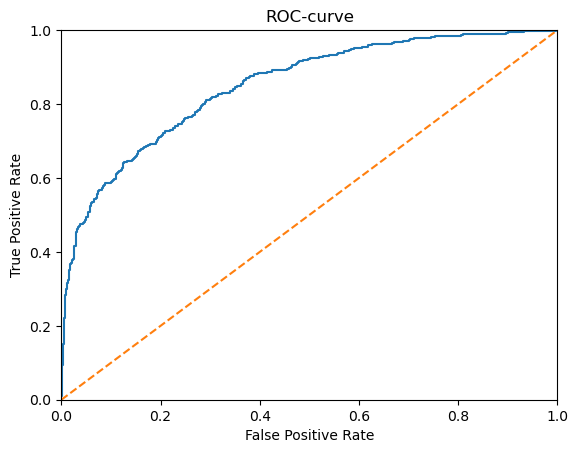

In [93]:
# predicting the probabilities of classifying an object as a class 1
probabilities_test_rf_up = best_model_random_forest_up.predict_proba(features_test)
probabilities_one_test_rf_up = probabilities_test_rf_up[:, 1]
# using the ROC curve function to determine the false positive rate, true positive rate and threshold
fpr_rf_up, tpr_rf_up, thresholds_rf_up = roc_curve(target_test, probabilities_one_test_rf_up)
# creating a graph and passing it false positive rate and true positive rate
plt.figure()
plt.plot(fpr_rf_up, tpr_rf_up)
# creating a dotted line to indicate a random model
plt.plot([0, 1], [0, 1], linestyle='--')
# setting limits on x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# setting the names of the axes and the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
# show the plot
plt.show()

Calculate ROC-AUC

In [98]:
auc_roc_rf_up_test = roc_auc_score(target_test, probabilities_one_test_rf_up)
print('ROC-AUC on the test sample of the random forest with an increasing sample:', auc_roc_rf_up_test)

ROC-AUC on the test sample of the random forest with an increasing sample: 0.8489374692856397


### Проверим модель рандомного леса с downsampling 

Checking the F1 metric

In [95]:
# Predicting the values in the test sample
predictions_test_random_forest = best_model_random_forest_down.predict(features_test)
# We consider the F1 metric for the validation sample
result_test_random_forest = f1_score(target_test, 
                                     predictions_test_random_forest)
print("F1 of the best downsampling random forest model:", best_result_random_forest_down)

F1 of the best downsampling random forest model: 0.6222222222222222


Checking the AUC-ROC metric

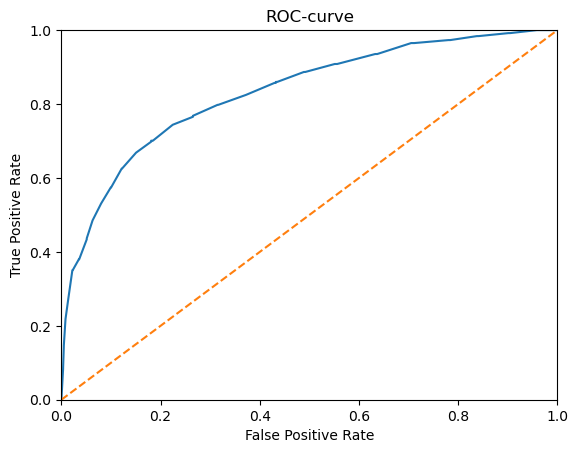

In [96]:
# predicting the probabilities of classifying an object as a class 1
probabilities_test_rf_down = best_model_random_forest_down.predict_proba(features_test)
probabilities_one_test_rf_down = probabilities_test_rf_down[:, 1]
# we use the ROC curve function to determine the false positive rate, true positive rate and threshold
fpr_rf_down, tpr_rf_down, thresholds_rf_down = roc_curve(target_test, probabilities_one_test_rf_down)
# creating a graph and passing it false positive rate and true positive rate
plt.figure()
plt.plot(fpr_rf_down, tpr_rf_down)
# creating a dotted line to indicate a random model
plt.plot([0, 1], [0, 1], linestyle='--')
# setting limits on x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# setting the names of the axes and the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
# show the plot
plt.show()

Calculate ROC-AUC

In [97]:
auc_roc_rf_down_test = roc_auc_score(target_test, probabilities_one_test_rf_down)
print('ROC-AUC on the RF upsampling test sample:', auc_roc_rf_down_test)

ROC-AUC on the RF upsampling test sample: 0.8311268633378506


### Conclusions on testing the model

As a result, the test showed that the best model is a random forest model using the upsampling method with the following characteristics:

F1 = 0.648,

AUC-ROC = 0.849

## Conclusions on the project

1. I started the project by uploading data. Saved the data to the data variable.



2. Then I moved on to data analysis.

    2.1. Using the info() method, I determined that a part of the data is missing in the tenure column. I decided to check if there is any connection with other data in order to fill them in. To do this, I built histograms for each feature. I looked at Pearson correlations and used phik_matrix to determine dependencies. As a result, I did not find the dependence of this variable with other data and decided to delete them. But the question remained open.: What could be done with them?

    2.2. During the analysis, I noticed the following data features:

         2.2.1. Active and inactive users are approximately equal

         2.2.2. Salaries are distributed suspiciously evenly

         2.2.3. There are a lot of users with zero balance

         2.2.4. Those who refused the bank's services are approximately 20%.

         2.2.5. The vast majority of users use one or two products of the bank.

         2.2.6. The median age is around 40 years.

         2.2.7. The duration of using the bank's services is distributed evenly among users, but those who use it for less than a year or more than 10 years are eliminated
         
    2.3. Checked the class imbalance. The ratio of remaining customers to those who have left the bank is about 80 to 20%.

    2.4. Divided the samples into training, validation and test samples in the proportions of 60/20/20. I removed the columns with the last name and id from the predictors, since this information is unlikely to help us classify users correctly

    2.5. Converted the data in the Geography, Gender columns into numerical variables using the OHE method. In order not to fall into the trap of fictitious signs, I passed drop_first=True.

    2.6. Standardized the data in all three samples
    


3. I moved on to the study of problem 

    3.1. I trained models of logistic regression, decision tree and random forest. I checked the F1 and AUC-ROC metrics on each of them and built a ROC curve. As a result, it turned out that the random forest model works best on data with an imbalance. F1 = 0.626, AUC-ROC = 0.863.

    3.2. To correct the imbalance, I used the downsampling technique. I trained the same models. I checked the F1 and AUC-ROC metrics on each of them and built a ROC curve. As a result, it also turned out that the random forest model works best. F1 = 0.622, AUC-ROC = 0.864. At the same time, the F1 metric of the logical regression increased from 0.330 to 0.514.

    3.3. For comparison, I used the upsampling technique. I trained the same models. I checked the F1 and AUC-ROC metrics on each of them and built a ROC curve. As a result, it also turned out that the random forest model works best. F1 = 0.649, AUC-ROC = 0.870.



4. Testing random forest models with upsampling and downsampling. 

    4.1. In the test sample, a random forest model trained on data using the upsampling technique showed the following metrics: F1 = 0.648, AUC-ROC = 0.849

    4.2. In the test sample, a random forest model trained on data using the downsampling technique showed the following metrics: F1 = 0.622, AUC-ROC = 0.831

    4.3. In total, we choose a random forest model with upsampling due to higher metrics.
    
    

5. Now this model can be used to identify customers who have a high risk of abandoning the bank's services. Now we can use this information to take measures to prevent them from leaving.